# Second Practical work

* Name Student 1: Daniel Toribio Bruna
* NIA Student 1: 100454242

  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [150]:
!pip install pycuda

We import the Python modules which we will use in the notebook (numpy, pycuda and time module)

In [151]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time

In [152]:
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook.

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [153]:
from os.path import join
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
!ls /content/drive/MyDrive/Images

chess.jpg  cloudsonjupi.jpg  digits.jpg  fence.jpg  hand-x-ray.jpg


## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [155]:
MYDRIVE="/content/drive/MyDrive/Images"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [156]:
image =  ["chess.jpg", "cloudsonjupi.jpg", "digits.jpg", "fence.jpg", "hand-x-ray.jpg"] # I create an array with the names of the images to access
# the images easier
IMAGE=join(MYDRIVE,image[4])

In [157]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/MyDrive/Images/hand-x-ray.jpg


Loads an image in a numpy variable, and show.

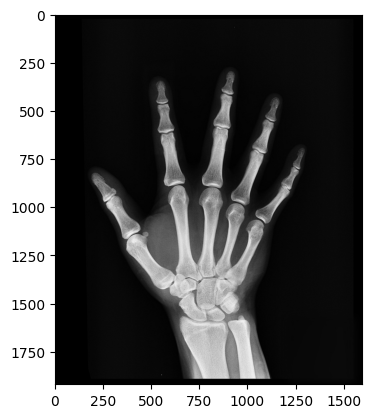

In [158]:
image=np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [159]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([[0.5, 0 , -0.5]])
filter3=np.array([[0.5],[0],[-0.5]])

filter4=np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

## FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [160]:
kernel_code  = """
__global__ void image_filter( float * src_image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * dst_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              )
{
    // Initialization of the variables which will be used for the filtered matrix
    int idxY; // It indicates the row of the element that the thread will modify
    int idxX; // It indicates the column of the element that the thread will modify
    int vX; // It indicates the element, in vector form, in the filtered image that the thread will compute
    idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we compute the row address in dst_image
    idxX = blockIdx.x*blockDim.x+threadIdx.x; // With this we compute the column address in dst_image

    // We also need to obtain information about the thread and block we are in
    // For the block we can use blockIdX.x and blockIdx.y and for the thread we can use threadIdx.x and threadIdx.y

   

    // Now we compute the vector position in the filtered matrix. 
    if ((idxY<NumRowsImg) && (idxX<NumColsImg)){ // check the thread is in a valid position (inside the range of the size of the image)
      vX=idxY*NumColsImg+idxX;
    }

    // Now, we will create a shared variable (tile_image), which can be accessed by all threads in the corresponding block. 
    // Its main advantage with respect to the global memory is that its access is faster. 
    // In this new local variable we will include the part of the image that the threads of the corresponding block
    // will use to compute their corresponding filtered value. 

    __shared__ float tile_image[ %(block_s)s + %(rows_of_filter)s - 1][%(block_s)s + %(cols_of_filter)s - 1];
    // In order to know the part of the image needed, we  will need at least the image corresponding with the block size. 
    // When computing the filtered result of a pixel in the middle area, the portion of the image needed will be in this region.
    // The problem comes when we have to compute the filtered values of pixels closer to the border because we will need to access 
    // rows and columns that are not inside the block area. To solve this we have to make the tile_image bigger to be able
    // to include all the rows and columns needed to compute the values of the filtered pixels. We will need to consider
    // as extra, the number of rows and columns of the filter. By doing this, pixels close to the border of the block will have access to
    // the required pixels of other blocks.
    // In summary, we have created a shared variable that will contains the block we are filtering surrounded by NumRowsFilter / 2
    // in the left and right and by NumColsFilter / 2 in the top and bottom, so we can obtain the necessary values to perform the operations.
    // We create two new variables that indicate the borders of the filter
    int half_filter_x = NumColsFilter / 2;
    int half_filter_y = NumRowsFilter / 2;

    // Now we have to fill the tile_image. To do this we will separate the task in two parts.

    // Fisrt we have to fill the central part which have the size of the block.
    // Each thread will fill the tile_image variable with its corresponding element in the src_image (Vx)
    tile_image[half_filter_y + threadIdx.y][half_filter_x + threadIdx.x] = src_image[vX];
    

    // Now we have to fill the part corresponding to the surrounding of the block of the image we are filtering. This part will be also
    // splitted in different parts as we need to fill each border in a specific way and take care of the corners.
    // Note that only those threads that are close to the border of the block will write this part of the tile memory

    // We will start filling the right border of tile_image
    if (threadIdx.x > (blockDim.x - half_filter_x - 1)){ // check whether the thread is in the right border
      int right = idxY * NumColsImg + (blockIdx.x + 1) * blockDim.x + (blockDim.x - threadIdx.x - 1);
      // idxY * NumColsImg is the start of the block 
      // (blockIdx.x + 1) * blockDim.x is that we go to the next block
      // (blockDim.x - threadIdx.x - 1) is that we go to the end of the block and substract the thread index
      // The result of these operations is that we obtain the symmetric element of the next block with respect to the 
      // element assigned to the thread

      int rel_position = right - idxY * NumColsImg; // Same as right, but relative, not with respect other blocks
      int border = idxY * NumColsImg + NumColsImg - 1; // End of the block

      // Here we fill tile_image
      tile_image[half_filter_y + threadIdx.y][(blockDim.x - threadIdx.x) * 2 + threadIdx.x + half_filter_x -1] =
      (rel_position >= NumColsImg) ? src_image[border] : src_image[right];
      // If the relative position is greater than NumColsImg, the thread is in the right border of the image, and we 
      // fill the outter border with the same value.
      // If not, we use the symmetric right value, provided by the next block.
    }


    // Now we will fill the left border of tile_image which will be the same as filling the right but now with the previous block
    if (threadIdx.x < half_filter_x){ // check whether the thread is in the left border

      int left = idxY * NumColsImg + (blockIdx.x - 1) * blockDim.x + (blockDim.x - threadIdx.x - 1);
      // idxY * NumColsImg is the start of the block 
      // (blockIdx.x - 1) * blockDim.x is that we go to the previous block
      // (blockDim.x - threadIdx.x - 1) is that we go to the end of the block and substract the thread index
      // The result of these operations is that we obtain the symmetric element of the previous block with respect to the 
      // element assigned to the thread

      int rel_position = left - idxY * NumColsImg; // Same as left, but relative, not with respect other blocks
      int border = idxY * NumColsImg; // Start of the block

      // Here we fill tile_image
      tile_image[half_filter_y + threadIdx.y][half_filter_x - threadIdx.x - 1] = (rel_position < 0) ? src_image[border] : src_image[left];
      // If the relative position is less than 0, the thread is in the left border of the image, 
      // and we fill the outter border with the same value. 
      // If not, we use the symmetric left value, provided by the previous block..
    }


    // Now we will fill the upper border of tile_image
    if (threadIdx.y < half_filter_y){ // check whether the thread is in the upper border

      int up = ((blockIdx.y - 1) * blockDim.y + (blockDim.x - threadIdx.y - 1)) * NumColsImg + idxX; 
      // We go to the block that is located above this block in the image, and 
      // obtain the symmetric element from that block with respect to the thread
      // (blockDim.x - threadIdx.y - 1)) * NumColsImg is the start of the upper block
      // (blockIdx.y - 1) * blockDim.y we go to the previous block
      // idxX is the respective symmetric thread position within the upper block 

      int rel_position = (blockIdx.y - 1) * blockDim.y + (blockDim.x - threadIdx.y - 1); // Relative symmetric position
      int border = (blockIdx.y * blockDim.y) * NumColsImg + idxX; // Upper border of the image 

      // Here we fill tile_image
      tile_image[half_filter_y - threadIdx.y - 1][half_filter_x + threadIdx.x] =
      (rel_position < 0) ? src_image[border] : src_image[up];
      // If the relative position is less than 0, the thread is in the upper border of the image, 
      // and we fill the outter border with the same value.
      // If not, we use the symmetric upper value, provided by the upper block.
    }


    // Now we will fill the lower border of tile_image
    if (threadIdx.y > (blockDim.y - half_filter_y - 1)){  // check whether the thread is in the lower border

      int down = ((blockIdx.y + 1) * blockDim.y + (blockDim.x - threadIdx.y - 1)) * NumColsImg + idxX; // We go to the block that is
      // located below this block (in the image), and obtain the symmetric element from that block with respect to the thread
      // Make use of (blockIdx.y + 1) * blockDim.y  we go to the next block
      // (blockDim.x - threadIdx.y - 1) * NumColsImg is the start of the lower block
      // By adding idxX we obtain the symmetric element in the lower block 

      int rel_position = (blockIdx.y + 1) * blockDim.y + (blockDim.x - threadIdx.y - 1); // Obtains relative position
      int border = (blockIdx.y * blockDim.y + (blockDim.y - 1)) * NumColsImg + idxX; // Lower border of the image 

     

      // Fill the tile memory
      tile_image[(blockDim.y - threadIdx.y) * 2 + threadIdx.y + half_filter_y - 1][half_filter_x + threadIdx.x] =
      (rel_position >= NumColsImg) ? src_image[border] : src_image[down];
      // If the relative position is larger than the number of columns, 
      // the thread is in a lower border of the image, and we fill the outter border with the same value.
      // If not, we use the symmetric lower value, provided by the lower block.
    }


    // Once we have filled the borders we have to fill the corners. We will follow the same strategy as with the border.
    // We will start with filling the upper left corner of tile_image

    if (threadIdx.y < half_filter_y && threadIdx.x < half_filter_x){ // Both x and y coordinates of the thread are located close to the upper
       // left corner
       int corner_up_left = ((blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg + (blockIdx.x - 1)*blockDim.x + (blockDim.x-threadIdx.x-1);
       // (blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg is the the upper row
       // (blockIdx.x - 1)*blockDim.x + (blockDim.x-threadIdx.x-1) is the first element of the upper row, that is, the symmetric with
       // respect to the x coordinate of the previous block
       int rel_y_position = (blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1); // Obtains relative position of the previous block with respect
       // to y coordinate
       int rel_x_position = (blockIdx.x - 1)*blockDim.x + (blockDim.x - threadIdx.x - 1); // Obtains relative position of the previous block with respect
       // to x coordinate

       int corner = (blockIdx.y * blockDim.y) * NumColsImg + blockIdx.x * blockDim.x; 

       // Here we fill tile_image upper left corner
       tile_image[threadIdx.y][threadIdx.x] = (rel_y_position < 0 || rel_x_position < 0) ? src_image[corner] : src_image[corner_up_left];
       // As tile_image is bigger than the block size, by inserting the element in [threadIdx.y][threadIdx.x], we are pointing to the corner
       // If any of the relative positions is negative, it means that we are in a corner of the original image (not just a tile corner), and we
       // will fill the element with the same value
    }


    // Now we will fill the upper right corner of tile_image
    if (threadIdx.y < half_filter_y && threadIdx.x > (blockDim.x - half_filter_x - 1)){ // y coordinate of the thread 
    // in the upper part of the block, while x coordinate of the thread in the right part

       
       int corner_up_right = ((blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg + (blockIdx.x + 1)*blockDim.x + (blockDim.x-threadIdx.x-1);
       // (blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg is the previous row of the image
       // (blockIdx.x + 1)*blockDim.x + (blockDim.x-threadIdx.x-1) is the next block and obtains 
       // the symmetric element wrt the x coordinate (of the next block)
       int rel_y_position = (blockIdx.y - 1)*blockDim.y + (blockDim.x - threadIdx.y - 1); // Obtains relative position 
       // of the previous block with respect to y coordinate
       int rel_x_position = (blockIdx.x + 1)*blockDim.x + (blockDim.x - threadIdx.x - 1); // Obtains relative position 
       // of the next block with respect to x coordinate

       int corner = (blockIdx.y * blockDim.y) * NumColsImg + NumColsImg - 1;

       // Here we fill tile_image upper right corner
       tile_image[threadIdx.y][(blockDim.x - 1) + half_filter_x + (blockDim.x - threadIdx.x)] = (rel_y_position < 0 || rel_x_position >= NumColsImg) ? src_image[corner] : src_image[corner_up_right];
       // If we are located in the actual upper right corner of the image, we will fill the element with the corner value.
       // However, if it is just a corner within the tile we will use the corner_up_right value.
    }


    // Now we will fill the lower left corner of tile_image

    if (threadIdx.y > (blockDim.y - half_filter_y - 1) && threadIdx.x < half_filter_x){ // Both x and y coordinates of the thread are located close to the lower
       // left corner
       
       int corner_lower_left = ((blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg + (blockIdx.x - 1)*blockDim.x + (blockDim.x-threadIdx.x-1);
       // (blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg is the next row
       // (blockIdx.x - 1)*blockDim.x + (blockDim.x-threadIdx.x-1) is the symmetric value of the thread, of the previous block in the next row
       int rel_y_position = (blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1); // relative position of the y coordinate of the thread within the next row
       int rel_x_position = (blockIdx.x - 1)*blockDim.x + (blockDim.x - threadIdx.x-1); // relative position of the y coordinate of the thread within the previous block

       int corner = (blockIdx.y * blockDim.y + (blockDim.y - 1)) * NumColsImg + blockIdx.x * blockDim.x;
      
       // Here we fill tile_image lower left corner applying the same logic as in the previous ones
       tile_image[blockDim.y - 1][half_filter_x - threadIdx.x - 1] = (rel_y_position >= NumColsImg || rel_x_position < 0) ? src_image[corner] : src_image[corner_lower_left];
    }


    // Now we will fill the lower right corner of tile_image
    if (threadIdx.y > (blockDim.y - half_filter_y - 1) && threadIdx.x > (blockDim.x - half_filter_x - 1)){ // Both x and y coordinates of the thread are located close to the lower
       // right corner
      
       int corner_down_right = ((blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg + (blockIdx.x + 1)*blockDim.x + (blockDim.x-threadIdx.x-1);
       // (blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1))*NumColsImg is the next row of the tile
       // (blockIdx.x + 1)*blockDim.x + (blockDim.x-threadIdx.x-1) is the symmetric element with respect to the next block of the next row of the current thread
       int rel_y_position = (blockIdx.y + 1)*blockDim.y + (blockDim.x - threadIdx.y - 1);
       int rel_x_position = (blockIdx.x + 1)*blockDim.x + (blockDim.x - threadIdx.x - 1);

       int corner = (blockIdx.y * blockDim.y) * NumColsImg + NumColsImg - 1;

       // Here we fill tile_image lower right corner applying the same logic as in the previous ones
       tile_image[(blockDim.y - 1) + half_filter_y + (blockDim.y - threadIdx.y)][(blockDim.x - 1) + half_filter_x + (blockDim.x - threadIdx.x)] = (rel_y_position >= NumColsImg || rel_x_position >= NumColsImg) ? src_image[corner] : src_image[corner_down_right];
    }

    // We will create another shared variable, local_filter, accessible by all threads in the block. 
    // That matrix will be filled with the values of the global filter. This will make the 
    // process of matrix multiplication faster, as the threads will not have to access to the global memory, but to the local shared one,
    // which is faster


    __shared__ float local_filter[%(rows_of_filter)s][%(cols_of_filter)s]; // we create a matrix of the same size as the filter
    if ((threadIdx.x < NumColsFilter) && (threadIdx.y < NumRowsFilter)){ // check if the index coincides with a valid position in the filter
      int filter_value =  threadIdx.y * NumColsFilter + threadIdx.x; // Given a row and a col in matrix form, we obtain the element in vector
      // form. Here we have followed the same reasoning as for Vx
      // Here we fill local_filter
      local_filter[threadIdx.y][threadIdx.x] = filter_mask[filter_value];
    }

    // We wait until all threads have filled the tiled memory with the corresponding image elements using __syncthreads()
    __syncthreads();

    // Now that we have created and filled tile_image with the part of the image needed for the threads of the block, 
    // and local_filter with the values of the filter, we can proceed to perform the multiplication part using a for loop

    float filtered_value = 0;
    for (int row = 0; row < NumRowsFilter; row++){ // Iterate through the rows of the filter
      for (int col = 0; col < NumColsFilter; col++){ // Iterate through the columns of the filter
        filtered_value += tile_image[row + threadIdx.y][col + threadIdx.x] * local_filter[row][col];
        // The filtered_value stores the sum of the products, as in a matrix multiplication
      }
    }

    //Here we check if the thread is in a valid position before modifying the filtered image
    if ((threadIdx.y < NumRowsImg) && (threadIdx.x < NumColsImg)){
      // As it is in a valid position, we store the resulting filtered value in dst_image variable, 
      // in the position previously computed, vX position
      dst_image[vX] = filtered_value;
      
    }
}

"""

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [161]:
image_shape=image.shape[0:2]

Set block size and grid size.

In [162]:
block_s=16 # We will use 16 as block size
block_size=(block_s,block_s,1)
grid_size=(int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)))

Allocates the target image memory.

In [163]:
result_image=np.zeros(image.shape,dtype=np.uint8)

In [164]:
depth = image.shape[2]

### Select the filter mask, and upload to the GPU device.

In [165]:
filter_mask=filter2.astype(np.float32)
filter_mask_gpu=gpuarray.to_gpu(filter_mask)

## Prepares the execution environment

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [166]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)

In [167]:
kernel = kernel_code % {
    'rows_of_filter': filter_mask.shape[0],
    'cols_of_filter': filter_mask.shape[1],
    'block_s': block_s,
}
# compile the kernel code
mod = SourceModule(kernel)
image_filter = mod.get_function ('image_filter')

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [168]:
%%timeit -r 10 -n 10 -o 
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer=(image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu=gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer=filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store,
                                                        #casting the data type from double to uint8

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


56.2 ms ± 7.67 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 56.2 ms ± 7.67 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

In [169]:
statistics=_

# Show results


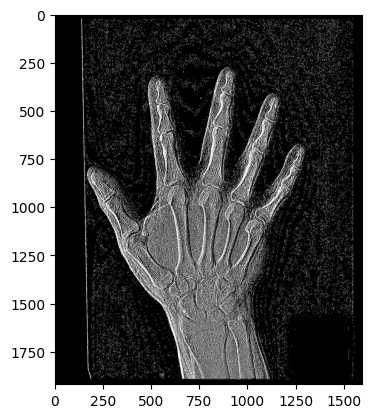

In [170]:
plt.figure()
plt.imshow(result_image)

In [171]:
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.05124466440001925
Worst execution time: 0.07839715729996896
Mean execution time: 0.05621644498000024 (0.007670340947647727 std dev)


# INDIVIDUAL CONCLUSIONS (Daniel Toribio 100454242):

The objective of this second exercise aligns with our initial practical task: generating a filtered image from a given image and filter mask. However, the focus has changed to incorporating GPU utilization and tiled (or shared) memory.

Tiled memory is a shared memory space among all threads within the same block. Each thread sequentially loads corresponding data onto the on-chip memory, waiting for it to be completed before utilization. The idea behind this memory type is to minimize each thread's global memory access, as accessing on-chip memory is faster and more efficient.

In this exercise, the information within the image is segmented into blocks. Each block has a tile memory, accessible by all threads within that block. Individual threads are responsible for filtering specific pixels from the original image stored in the shared memory. Consequently, the tile memory's dimensions match those of a block (e.g., 16x16), plus a relative size depending on the dimensions of the filter mask.

Special consideration is given to pixels at the block borders. For instance, when using a 5x5 filter, filtering a pixel requires its surrounding pixels from 2 rows and 2 columns above and below. Hence, the tile memory dimensions become 20x20.

The filling process starts after defining the tile memory dimensions. Each thread fills its corresponding pixel from the original image into the corresponding tile position. Threads situated along the borders symmetrically complete extra positions by acquiring pixel information from adjacent blocks. Additionally, threads at these locations handle corner cases, always verifying their valid position with an if condition before altering a tile memory element. Simultaneous operation is ensured as threads within the block concurrently fill various tile elements.

Once all threads contribute to filling the tile memory, a waiting period is used for synchronization. Subsequently, the computation of the filtered image starts. Each thread filters a designated pixel within its block, storing the outcome in the dst_img variable.

In summary, this exercise involves filtering images with various dimension filters while implementing tile memory. Notably, the algorithm's execution time is less than that of the initial practical work, attributing this improvement to the faster shared memory compared to global memory. It's crucial to acknowledge numerical differences, given the use of GPUs with 32-bit precision instead of the 64-bit precision found in CPUs. Consequently, while GPUs are notably swift, their precision may not match that of CPUs.
